Install the necessary libraries

In [ ]:
!pip install -U nvidia-smi

     |████████████████████████████████| 276kB 4.5MB/s 
  Created wheel for sorcery: filename=sorcery-0.2.1-cp36-none-any.whl size=10768 sha256=226658d2d3306927390ee1add0c38c798af7d03b7d4f53bdc93a6adbad7a9dfb
  Stored in directory: /root/.cache/pip/wheels/9f/4f/7e/e9df57327c0fdb1f6f1fbf29ae642ac9641295ff5953eea21c
  Created wheel for littleutils: filename=littleutils-0.2.2-cp36-none-any.whl size=7051 sha256=9df786fbb6bd4443810f92f354706eb4b976b5beda3636340f3dc9693bafa7ab
  Stored in directory: /root/.cache/pip/wheels/53/16/9f/ac67d15c40243754fd73f620e1b9b6dedc20492ecc19a2bae1
Successfully built sorcery littleutils
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: pluggy 0.7.1
    Uninstalling pluggy-0.7.1:
      Successfully uninstalled pluggy-0.7.1
  Found existing installation: pytest 3.6.4
    Uninstalling pytest-3.6.4:
      Successfully uninstalled pytest-3.6.4


In [ ]:
!/usr/local/cuda/bin/nvcc --version

!nvidia-smi

!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
/bin/bash: nvidia-smi: command not found
/bin/bash: nvidia-smi: command not found


In [ ]:
!pip uninstall keras
!pip install keras==2.2.4
!pip uninstall tensorflow
!pip install "tensorflow>=1.15,<2.0"
!pip install --upgrade tensorflow-hub
!pip install git+https://www.github.com/keras-team/keras-contrib.git

Uninstalling Keras-2.2.4:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/Keras-2.2.4.dist-info/*
    /usr/local/lib/python3.6/dist-packages/docs/*
    /usr/local/lib/python3.6/dist-packages/keras/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.6/dist-packages/docs/md_autogen.py
    /usr/local/lib/python3.6/dist-packages/docs/update_docs.py
Proceed (y/n)? y
  Successfully uninstalled Keras-2.2.4
  Using cached https://files.pythonhosted.org/packages/5e/10/aa32dad071ce52b5502266b5c659451cfd6ffcbf14e6c8c4f16c0ff5aaab/Keras-2.2.4-py2.py3-none-any.whl
Uninstalling tensorflow-1.15.4:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/freeze_graph
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-1.15.4.dist-info/*
    /usr/local/lib

Import the required libraries

In [ ]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import spacy
warnings.simplefilter('ignore')
from pprint import pprint
nlp = spacy.load('en', disable=['parser', 'ner'])
nlp_sm = spacy.load("en_core_web_sm")

Read the annotated dataset (Output from the survey with TASSY)

In [ ]:
sentences_file = "https://raw.githubusercontent.com/kanishk2509/Automated-Detection-of-Bias-Inducing-Words-in-English-News-Articles/main/annotated-datasets/labeled_sentences_dataset_3.csv"
data = pd.read_csv(sentences_file, encoding='utf-8')
data = data.drop(['Unnamed: 0', "article"], axis=1)
data = data.fillna(method="ffill")
data.tail(3)

,sentence,news_link,outlet,topic,type,group_id,num_sent,Label_bias,Label_opinion,biased_words
1697,Democrats and Republicans stood and applauded ...,https://eu.usatoday.com/story/news/politics/20...,usa-today,gender,center,85,1,Non-biased,Entirely factual,['saluted']
1698,"As a self-described Democratic socialist, Sen....",https://www.foxnews.com/politics/how-did-berni...,fox-news,middle-class,right,85,1,Non-biased,Entirely factual,"['outspoken', 'self-described']"
1699,"During the segment, Colbert also bemoaned the ...",https://www.breitbart.com/entertainment/2018/1...,breitbart,white-nationalism,right,85,1,Non-biased,No agreement,['bemoaned']


Make a copy of the dataset

In [ ]:
sentence_df = data.copy()
sentence_df.head(5)

,sentence,news_link,outlet,topic,type,group_id,num_sent,Label_bias,Label_opinion,biased_words
0,YouTube is making clear there will be no “birt...,https://eu.usatoday.com/story/tech/2020/02/03/...,usa-today,elections-2020,center,1,1,Biased,Somewhat factual but also opinionated,"['belated', 'birtherism']"
1,The increasingly bitter dispute between Americ...,https://www.nbcnews.com/news/sports/women-s-te...,msnbc,sport,left,1,1,Non-biased,Entirely factual,"['bitter', 'spilled']"
2,So while there may be a humanitarian crisis dr...,https://www.alternet.org/2019/01/here-are-5-of...,alternet,immigration,left,1,1,Biased,Expresses writer’s opinion,"['crisis', 'no']"
3,A professor who teaches climate change classes...,https://www.breitbart.com/politics/2019/05/09/...,breitbart,environment,right,1,1,Non-biased,No agreement,['legitimate']
4,"Looking around the United States, there is nev...",https://thefederalist.com/2020/03/11/woman-who...,federalist,abortion,right,1,1,Biased,Somewhat factual but also opinionated,"['killing', 'never', 'developing', 'humans', '..."


In [ ]:
# label2index = {
#     'O': 0,
#     'Neutral': 1,
#     'B-Biased': 2,
#     'I-Biased': 3
# }
# n_lab = len(label2index)

In [ ]:
label2index = {
    'O': 0,
    'Neutral': 1,
    'Biased': 2
}
n_lab = len(label2index)

In [ ]:
from spacy.tokenizer import Tokenizer
tokenizer = Tokenizer(nlp.vocab)

def tokenize_sentence(sentence):
  sequence = []
  toks = tokenizer(sentence)
  for token in toks:
    sequence.append(token.text.lower())
  return sequence

def get_as_list(text):
  list = []
  for word in text.split():
    list.append(''.join(e for e in word if e.isalnum()))
  return list

In [ ]:
sentences = sentence_df.sentence
f"Number of sentences => {len(sentences)}"

'Number of sentences => 1700'

In [ ]:
import re
###############################################################
def decide_label(token, row_i):
  if token == 'padded':
    return 'O'

  biased_words = get_as_list(data.biased_words[row_i])

  if token in biased_words:
    return 'Biased'
  else:
    return 'Neutral'

def label_token(token, row_i):
  token_clean = re.findall('[\w]+', token.lower())
  if len(token_clean) > 0:
    return decide_label(token_clean[0], row_i)
  else:
    return 'Neutral'

In [ ]:
max_len = 50
X = [[w for w in tokenize_sentence(s)] for s in sentences]
new_X = []

import re
for seq in X:
  new_seq = []
  for i in range(max_len):
    try:
      new_seq.append(seq[i])
    except:
      new_seq.append("PADDED")
  new_X.append(new_seq)

In [ ]:
print(new_X[1])

['the', 'increasingly', 'bitter', 'dispute', 'between', 'american', 'women’s', 'national', 'soccer', 'team', 'and', 'the', 'u.s.', 'soccer', 'federation', 'spilled', 'onto', 'the', 'field', 'wednesday', 'night', 'when', 'players', 'wore', 'their', 'warm-up', 'jerseys', 'inside', 'outin', 'a', 'protest', 'before', 'their', '3-1', 'victory', 'over', 'japan.', 'PADDED', 'PADDED', 'PADDED', 'PADDED', 'PADDED', 'PADDED', 'PADDED', 'PADDED', 'PADDED', 'PADDED', 'PADDED', 'PADDED', 'PADDED']


In [ ]:
X_tagged = []
for i in range(0, len(new_X)):
  t = []
  for word in new_X[i]:
    t.append(label_token(word, i))
  X_tagged.append(t)

In [ ]:
print(X_tagged[1])

['Neutral', 'Neutral', 'Biased', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Biased', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [ ]:
len(X_tagged)

1700

In [ ]:
def bio_tagger(X_tagged):
  X_bio_tagged = []
  prev_tag = "Neutral"
  for sentence in X_tagged:
    sentence_bio_tagged = []
    for tag in sentence:
      if tag == "Neutral": 
        sentence_bio_tagged.append(tag)
        prev_tag = tag
        continue
      if tag == "Biased" and prev_tag == "Neutral": 
        sentence_bio_tagged.append("B-"+tag)
        prev_tag = tag
      elif prev_tag == "Biased" and prev_tag == tag: # Inside NE
        sentence_bio_tagged.append("I-"+tag)
        prev_tag = tag
      # elif prev_tag != "Neutral" and prev_tag != tag: # Adjacent NE
      #   sentence_bio_tagged.append("B-"+tag)
      #   prev_tag = tag
      elif tag == "O": 
        sentence_bio_tagged.append(tag)
        prev_tag = tag
        continue
    X_bio_tagged.append(sentence_bio_tagged)
  return X_bio_tagged

In [ ]:
X_bio_tagged = bio_tagger(X_tagged)

In [ ]:
for i in range(len(X_tagged[:50])):
  print(X_tagged[i])

['Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Biased', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Biased', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['Neutral', 'Neutral', 'Biased', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Biased', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral'

In [ ]:
for i in range(len(X_bio_tagged[:50])):
  print(X_bio_tagged[i])

['Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'B-Biased', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'B-Biased', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['Neutral', 'Neutral', 'B-Biased', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'B-Biased', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', '

In [ ]:
from keras.preprocessing.sequence import pad_sequences
y = []
for i in range(0, len(X_tagged)):
  t = []
  for tag in X_tagged[i]:
    t.append(label2index[tag])
  y.append(t)

In [ ]:
for i in range(len(y[:50])):
  print(y[i])

[1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 0, 0, 

In [ ]:
print(y[20])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
print(len(y))

1700


In [ ]:
from keras.utils import to_categorical
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=0)
y = [to_categorical(i, num_classes=n_lab) for i in y]

In [ ]:
y[20]

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size=0.1, random_state=2)
print (f"{len(X_train)}, {len(X_test)}, {len(y_train)}, {len(y_test)}")

1530, 170, 1530, 170


In [ ]:
!pip install liwc

import liwc
parse, category_names = liwc.load_token_parser(
    '/content/drive/My Drive/Bias_Lexica_Kanishka_WS1920/datasets/linguistics/LIWC2015_English.dic'
    )

from collections import Counter
def get_category_counts_for_sentence(sentence):
  liwc_cat_counts = Counter(category for token in sentence for category in parse(token))
  return liwc_cat_counts

def calculate_liwc_features(token, sentence):
  liwc_sentence_counts = get_category_counts_for_sentence(sentence)
  liwc_item_counts = Counter(category for t in [token] for category in parse(t))

  #  for token
  negemo_token_count = liwc_item_counts['negemo (Negative Emotions)']
  posemo_token_count = liwc_item_counts['posemo (Positive Emotions)']
  affective_token_count = liwc_item_counts['affect (Affect)']
  drive_token_count = liwc_item_counts['drives (Drives)']
  anger_token_count = liwc_item_counts['anger (Anger)']
  risk_token_count = liwc_item_counts['risk (Risk)']

  # For sentence
  negemo_sent_count = liwc_sentence_counts['negemo (Negative Emotions)']
  posemo_sent_count = liwc_sentence_counts['posemo (Positive Emotions)']
  affective_sent_count = liwc_sentence_counts['affect (Affect)']
  drive_sent_count = liwc_sentence_counts['drives (Drives)']
  anger_sent_count = liwc_sentence_counts['anger (Anger)']
  risk_sent_count = liwc_sentence_counts['risk (Risk)']

  # calculate relative count ratios wrt the entire sentence
  if negemo_token_count > 0:
    negemo_rel = 1 + (negemo_token_count / negemo_sent_count )
  else:
    negemo_rel = 0.0

  if posemo_token_count > 0:
    posemo_rel = 1+ (posemo_token_count / posemo_sent_count )
  else:
    posemo_rel = 0.0

  if affective_token_count > 0:
    affective_rel = 1+  (affective_token_count / affective_sent_count )
  else:
    affective_rel = 0.0
  
  if drive_token_count > 0:
    drive_rel = 1 + (drive_token_count / drive_sent_count)
  else:
    drive_rel = 0.0
  
  if anger_token_count > 0:
    anger_rel = 1 + (anger_token_count / anger_sent_count)
  else:
    anger_rel = 0.0

  if risk_token_count > 0:
    risk_rel = 1 + (risk_token_count / risk_sent_count)
  else:
    risk_rel = 0.0

  # print(f'{negemo_rel} {posemo_rel} {affective_rel} {drive_rel} {anger_rel} {risk_rel}')

  return np.array([negemo_rel, posemo_rel, affective_rel, drive_rel, anger_rel, risk_rel])

def extract_relative_liwc_features(tokens):
  li = np.zeros(shape=(50, 6))
  for i in range(50):
    li[i] = calculate_liwc_features(tokens[i], tokens)
  return li

In [ ]:
li = np.zeros(shape=(len(X_train), 50, 6))
count = 0
for sentence in X_train:
  count += 1
  print(count)
  for i in range(len(sentence)):
    li[i] = extract_relative_liwc_features(sentence)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [ ]:
li.shape

(1530, 50, 6)

In [ ]:
li_test = np.zeros(shape=(len(X_test), 50, 6))
count = 0
for sentence in X_test:
  count += 1
  print(count)
  for i in range(len(sentence)):
    li_test[i] = extract_relative_liwc_features(sentence)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170


In [ ]:
li_test.shape

(170, 50, 6)

In [ ]:
print(li[6])

[[0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         1.33333333 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         1.33333333 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.        

In [ ]:
batch_size = 32
max_len = 50
n_dims_elmo = 1024
n_dims_liwc = 6

In [ ]:
n_tr_samples = 44 * batch_size
X_TR = X_train[:n_tr_samples]
X_TR_LIWC = li[:n_tr_samples]
y_TR = y_train[:n_tr_samples]

n_tes_samples = -3 * batch_size
X_VAL = X_train[n_tes_samples:]
X_VAL_LIWC = li[n_tes_samples:]
y_VAL = y_train[n_tes_samples:]

f'{len(X_TR)} {len(X_TR_LIWC)} {len(y_TR)} {len(X_VAL)} {len(X_VAL_LIWC)} {len(y_VAL)}'
# f'{len(X_TR)} {len(y_TR)} {len(X_VAL)} {len(y_VAL)}'

'1408 1408 1408 96 96 96'

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import keras
from keras import backend as K
sess = tf.Session()
K.set_session(sess)
import logging
tf.get_logger().setLevel(logging.ERROR)

In [ ]:
elmo_model = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

In [ ]:
def ELMOEmbeddingLayer(x):
  embeddings_tensor = elmo_model(inputs={
                          "tokens": tf.squeeze(tf.cast(x, tf.string)),
                          "sequence_len": tf.constant(batch_size*[max_len])
                    },
                    signature="tokens",
                    as_dict=True)["elmo"]
  return embeddings_tensor

In [ ]:
idx2label = {i: w for w, i in label2index.items()}
idx2label

{0: 'O', 1: 'Neutral', 2: 'Biased'}

In [ ]:
def pred2label(pred):
  out = []
  for pred_i in pred:
      out_i = []
      for p in pred_i:
          p_i = np.argmax(p)
          out_i.append(idx2label[p_i].replace("PADDED", "O"))
      out.append(out_i)
  return out

In [ ]:
from keras_contrib.layers import CRF
from keras.models import Sequential, Model
from keras.layers import GRU, Dropout, Embedding, Bidirectional, LSTM, Lambda, Input, TimeDistributed, Dense, Masking, InputLayer, Reshape, Flatten, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D
from keras.layers import add
from keras.layers import concatenate
from keras.utils import plot_model
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from keras.constraints import maxnorm

# Single Input model TM1

In [ ]:
def get_single_input_model(lstm_cells=344, dense_cells=344, d1=0.25, rd1=0.25, d2 = 0.25, rd2=0.25):
  input_text = Input(shape=(np.array(X_train).shape[-1], ), dtype=tf.string)
  embedding = Lambda(ELMOEmbeddingLayer, output_shape=(None, n_dims_elmo))(input_text)
  x = Bidirectional(LSTM(units=lstm_cells, return_sequences=True, recurrent_dropout=rd1, dropout=d1))(embedding)
  x_rnn = Bidirectional(LSTM(units=lstm_cells, return_sequences=True, recurrent_dropout=rd2, dropout=d2))(x)
  x = add([x, x_rnn])  # residual connection to the first biLSTM
  out = TimeDistributed(Dense(n_lab, activation="softmax"))(x)

  model = Model(input_text, out)
  model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
  return model

Hyper-parameter tuning using GridSearchCV

In [ ]:
model = KerasRegressor(build_fn=get_single_input_model, epochs=15, batch_size=32, verbose=1)
neurons = [256, 512, 1024]
dropout_rates = [0.15, 0.20, 0.25]
param_grid = dict(lstm_cells=neurons, dense_cells=neurons, d1=dropout_rates, rd1=dropout_rates, d2=dropout_rates, rd2=dropout_rates)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1)
grid_result = grid.fit(np.array(X_TR), np.array(y_TR))

Epoch 1/15
1120/1126 [============================>.] - ETA: 3s - loss: 0.2446 - crf_viterbi_accuracy: 0.9251 Epoch 1/15


Finding the optimal hyperparameters

# Multi input model TM2

In [ ]:
def get_mutli_input_model():

  # tokens
  input_x = Input(shape=(max_len,), dtype=tf.string) 

  # first branch operates on text input and generates ELMO embeddings
  x_elmo_embedding = Lambda(ELMOEmbeddingLayer, output_shape=(max_len, n_dims_elmo))(input_x)
  x_bi_1 = Bidirectional(LSTM(units=344, return_sequences=True, recurrent_dropout=0.25, dropout=0.25))(x_elmo_embedding)
  x_bi_2 = Bidirectional(LSTM(units=344, return_sequences=True, recurrent_dropout=0.25, dropout=0.25))(x_bi_1)
  x = add([x_bi_1, x_bi_2])  

  # LIWC embeddings
  input_y = Input(shape=(50, n_dims_liwc), dtype=tf.int32) 

  # second branch for LIWC processing
  y_liwc_embedding = Embedding(input_dim=10000, output_dim=8, input_length=(max_len, n_dims_liwc), trainable=True)(input_y)
  reshaped_liwc_embedding = Reshape((50, (8 * n_dims_liwc)))(y_liwc_embedding)
  y = GRU(344, return_sequences=True)(reshaped_liwc_embedding)
  y = Dropout(0.20)(y)

  # merge layer results
  concat = concatenate([x, y])

  # pass the merged results further
  out = TimeDistributed(Dense(n_lab, activation="softmax"))(concat)

  model = Model([input_x, input_y], out)
  model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
  return model

# Baselines

Random assignment

In [ ]:
len(test_labels)

160

In [ ]:
test_labels[0]

In [ ]:
def random_assignment(test_labels):
  all_new_labels = []
  for i in range(len(test_labels)):
    current_label_seq = test_labels[i]
    new_labels = []
    current_bias_tok_counter = 0
    for j in range(len(current_label_seq)):
      current_label = current_label_seq[j]
      if current_label == 'O':
        new_labels.append(current_label)
      elif current_label == 'Biased':
        new_labels.append('Neutral')
        current_bias_tok_counter += 1
      else:
        new_labels.append('Neutral')
    
    random_pos = np.random.choice(25, current_bias_tok_counter)
    for k in random_pos:
      new_labels[k] = 'Biased'
    all_new_labels.append(new_labels)
  return all_new_labels

In [ ]:
return np.random.choice(50, 2)

In [ ]:
pred_labels_bs1 = random_assignment(test_labels)
print(pred_labels_bs1)

[['Neutral', 'Neutral', 'Neutral', 'Neutral', 'Biased', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Biased', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['Neutral', 'Biased', 'Biased', 'Biased', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Biased', 'Neutral', 'Neutral', 'Neutral', 'Biased', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Biased', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Ne

In [ ]:
print(pred_labels_bs1[20])

['Neutral', 'Neutral', 'Neutral', 'Neutral', 'Biased', 'Biased', 'Neutral', 'Biased', 'Neutral', 'Biased', 'Biased', 'Biased', 'Neutral', 'Biased', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Biased', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [ ]:
len(pred_labels_bs1)

160

In [ ]:
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels_bs1)))

F1-score: 8.9%


In [ ]:
print(accuracy_score(test_labels, pred_labels_bs1))

0.8935


In [ ]:
print(classification_report(test_labels, pred_labels_bs1))

              precision    recall  f1-score   support

      eutral       0.04      0.05      0.04       504
       iased       0.14      0.13      0.14       506

   micro avg       0.09      0.09      0.09      1010
   macro avg       0.09      0.09      0.09      1010
weighted avg       0.09      0.09      0.09      1010



# Train TM1

> LSTM cells - 256

> Dropout - 20%

> Activation - ReLU

In [ ]:
tm1_model = get_single_input_model()

In [ ]:
tm1_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
lambda_11 (Lambda)              (None, None, 1024)   0           input_13[0][0]                   
__________________________________________________________________________________________________
bidirectional_21 (Bidirectional (None, None, 512)    2623488     lambda_11[0][0]                  
__________________________________________________________________________________________________
bidirectional_22 (Bidirectional (None, None, 512)    1574912     bidirectional_21[0][0]           
__________________________________________________________________________________________________
add_11 (Ad

In [ ]:
plot_model(tm1_model, to_file='tm1_model_plot.png')

In [ ]:
history_tm1 = tm1_model.fit(
    np.array(X_TR), np.array(y_TR), 
    validation_data=(np.array(X_VAL), np.array(y_VAL)), 
    batch_size=batch_size, 
    epochs=10, 
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')],
    verbose=1
)

Train on 1408 samples, validate on 96 samples
Epoch 1/10
1408/1408 [==============================] - 487s 346ms/step - loss: 0.2220 - crf_viterbi_accuracy: 0.9254 - val_loss: 0.1349 - val_crf_viterbi_accuracy: 0.9562
Epoch 2/10
1408/1408 [==============================] - 487s 346ms/step - loss: 0.1318 - crf_viterbi_accuracy: 0.9553 - val_loss: 0.1255 - val_crf_viterbi_accuracy: 0.9585
Epoch 3/10
1408/1408 [==============================] - 481s 342ms/step - loss: 0.1208 - crf_viterbi_accuracy: 0.9582 - val_loss: 0.1245 - val_crf_viterbi_accuracy: 0.9596
Epoch 4/10
1408/1408 [==============================] - 486s 345ms/step - loss: 0.1110 - crf_viterbi_accuracy: 0.9601 - val_loss: 0.1324 - val_crf_viterbi_accuracy: 0.9592
Epoch 5/10
1408/1408 [==============================] - 482s 342ms/step - loss: 0.1009 - crf_viterbi_accuracy: 0.9637 - val_loss: 0.1270 - val_crf_viterbi_accuracy: 0.9600
Epoch 6/10
1408/1408 [==============================] - 481s 341ms/step - loss: 0.0890 - crf_v

In [ ]:
hist_tm1 = pd.DataFrame(history_tm1.history)

In [ ]:
print(hist_tm1.keys())

Index(['val_loss', 'val_crf_viterbi_accuracy', 'loss', 'crf_viterbi_accuracy'], dtype='object')


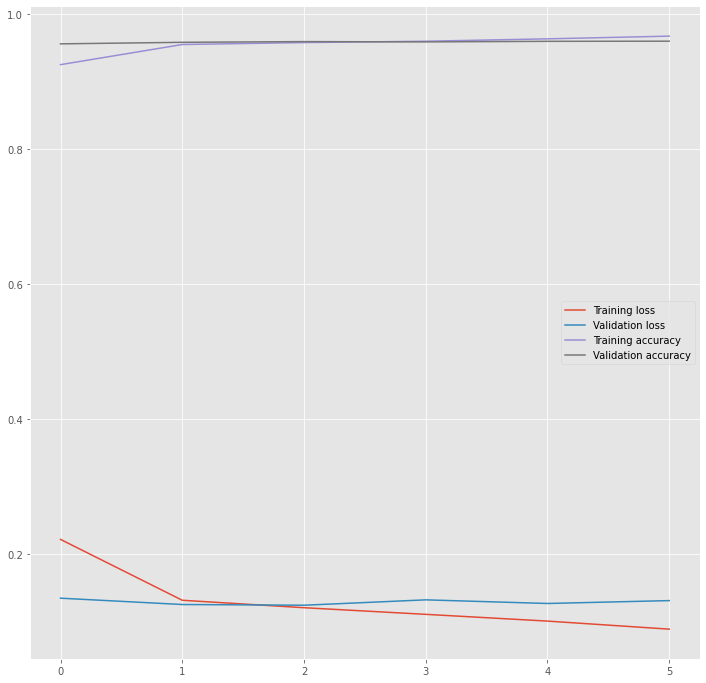

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(12, 12))
plt.plot(hist_tm1["loss"], label='Training loss')
plt.plot(hist_tm1["val_loss"], label='Validation loss')
plt.plot(hist_tm1["crf_viterbi_accuracy"], label='Training accuracy')
plt.plot(hist_tm1["val_crf_viterbi_accuracy"], label='Validation accuracy')
plt.legend()

In [ ]:
# test_predictions_tm1 = tm1_model.predict([np.array(X_test[:160]), np.array(li_test[:160])], verbose=1)
test_predictions_tm1 = tm1_model.predict(np.array(X_test[:160]), verbose=1)

160/160 [==============================] - 47s 295ms/step


In [ ]:
predicted_labels_tm1 = pred2label(test_predictions_tm1)
test_labels = pred2label(y_test[:160])

In [ ]:
print(predicted_labels_tm1[20])

['Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Biased', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [ ]:
print(test_labels[20])

['Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Biased', 'Neutral', 'Biased', 'Neutral', 'Biased', 'Biased', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Biased', 'Biased', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Biased', 'Biased', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [ ]:
!pip install seqeval

     |████████████████████████████████| 51kB 3.1MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp36-none-any.whl size=16171 sha256=f8fad0c730aa3a7cefe57fe12b5679c840e74508d76760692015786b3026b0c1
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval


In [ ]:
from seqeval.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, performance_measure
print("F1-score: {:.1%}".format(f1_score(test_labels, predicted_labels_tm1)))

F1-score: 36.9%


In [ ]:
print(recall_score(test_labels, predicted_labels_tm1))

0.2861386138613861


In [ ]:
print(classification_report(test_labels, predicted_labels_tm1))

              precision    recall  f1-score   support

      eutral       0.36      0.24      0.29       504
       iased       0.78      0.33      0.46       506

   micro avg       0.52      0.29      0.37      1010
   macro avg       0.57      0.29      0.38      1010
weighted avg       0.57      0.29      0.38      1010



In [ ]:
i = 20
p = np.argmax(test_predictions_tm1[i], axis=-1)
print("{:25} {:25} {}".format("Word", "True", "Pred"))
print("="*65)
for w, true, pred in zip(X_test[i], np.argmax(y_test[i], -1), p):
    if w != "PADDED":
        print("{:25}{:25} {}".format(w, idx2label[true], idx2label[pred]))

Word                      True                      Pred
tellingly,               Neutral                   Neutral
when                     Neutral                   Neutral
not                      Neutral                   Neutral
constrained              Neutral                   Neutral
by                       Neutral                   Neutral
the                      Neutral                   Neutral
debate                   Neutral                   Neutral
format,                  Neutral                   Neutral
these                    Neutral                   Neutral
same                     Biased                    Neutral
politicians              Neutral                   Neutral
push                     Biased                    Neutral
the                      Neutral                   Neutral
same                     Biased                    Neutral
narrative                Biased                    Neutral
to                       Neutral                   Neutral

# Train TM1 v2

> LSTM cells - 344

> Dropout - 25%

> Activation - softmax

In [ ]:
tm1_model = get_single_input_model()

In [ ]:
tm1_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
lambda_8 (Lambda)               (None, None, 1024)   0           input_8[0][0]                    
__________________________________________________________________________________________________
bidirectional_15 (Bidirectional (None, None, 688)    3767488     lambda_8[0][0]                   
__________________________________________________________________________________________________
bidirectional_16 (Bidirectional (None, None, 688)    2842816     bidirectional_15[0][0]           
__________________________________________________________________________________________________
add_8 (Add

In [ ]:
plot_model(tm1_model, to_file='tm1_model_plot.png')

In [ ]:
history_tm1 = tm1_model.fit(
    np.array(X_TR), np.array(y_TR), 
    validation_data=(np.array(X_VAL), np.array(y_VAL)), 
    batch_size=batch_size, 
    epochs=10, 
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')],
    verbose=1
)

Train on 1408 samples, validate on 96 samples
Epoch 1/10
1408/1408 [==============================] - 609s 433ms/step - loss: 0.1983 - acc: 0.9320 - val_loss: 0.1237 - val_acc: 0.9585
Epoch 2/10
1408/1408 [==============================] - 602s 428ms/step - loss: 0.1217 - acc: 0.9557 - val_loss: 0.1196 - val_acc: 0.9594
Epoch 3/10
1408/1408 [==============================] - 602s 428ms/step - loss: 0.1107 - acc: 0.9587 - val_loss: 0.1142 - val_acc: 0.9604
Epoch 4/10
1408/1408 [==============================] - 609s 432ms/step - loss: 0.1022 - acc: 0.9618 - val_loss: 0.1159 - val_acc: 0.9598
Epoch 5/10
1408/1408 [==============================] - 610s 433ms/step - loss: 0.0921 - acc: 0.9645 - val_loss: 0.1172 - val_acc: 0.9583
Epoch 6/10
1408/1408 [==============================] - 620s 440ms/step - loss: 0.0811 - acc: 0.9691 - val_loss: 0.1217 - val_acc: 0.9604


In [ ]:
hist_tm1 = pd.DataFrame(history_tm1.history)

In [ ]:
print(hist_tm1.keys())

Index(['val_loss', 'val_acc', 'loss', 'acc'], dtype='object')


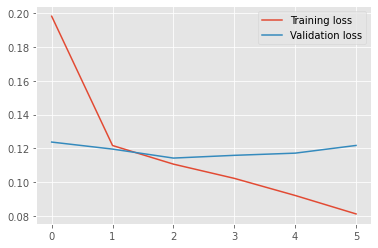

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.plot(hist_tm1["loss"], label='Training loss')
plt.plot(hist_tm1["val_loss"], label='Validation loss')
plt.legend()

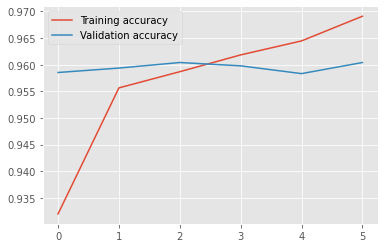

In [ ]:
plt.plot(hist_tm1["acc"], label='Training accuracy')
plt.plot(hist_tm1["val_acc"], label='Validation accuracy')
plt.legend()

In [ ]:
# test_predictions_tm1 = tm1_model.predict([np.array(X_test[:160]), np.array(li_test[:160])], verbose=1)
test_predictions_tm1 = tm1_model.predict(np.array(X_test[:160]), verbose=1)

160/160 [==============================] - 53s 332ms/step


In [ ]:
predicted_labels_tm1 = pred2label(test_predictions_tm1)
test_labels = pred2label(y_test[:160])

In [ ]:
print(predicted_labels_tm1[20])

['Neutral', 'Neutral', 'Neutral', 'Biased', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [ ]:
print(test_labels[20])

['Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Biased', 'Neutral', 'Biased', 'Neutral', 'Biased', 'Biased', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Biased', 'Biased', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Biased', 'Biased', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [ ]:
!pip install seqeval

     |████████████████████████████████| 51kB 3.0MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp36-none-any.whl size=16171 sha256=2677e563793464e5110237e70cc49b103484856cb3e0b5e5660ede8ee52a0c56
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval


In [ ]:
from seqeval.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, performance_measure
print("F1-score: {:.1%}".format(f1_score(test_labels, predicted_labels_tm1)))

F1-score: 41.8%


In [ ]:
print(recall_score(test_labels, predicted_labels_tm1))

0.3425742574257426


In [ ]:
print(accuracy_score(test_labels, predicted_labels_tm1))

0.954


In [ ]:
print(classification_report(test_labels, predicted_labels_tm1))

              precision    recall  f1-score   support

      eutral       0.38      0.28      0.32       504
       iased       0.76      0.40      0.52       506

   micro avg       0.54      0.34      0.42      1010
   macro avg       0.57      0.34      0.42      1010
weighted avg       0.57      0.34      0.42      1010



In [ ]:
i = 23
p = np.argmax(test_predictions_tm1[i], axis=-1)
print("{:25} {:25} {}".format("Word", "True", "Pred"))
print("="*65)
for w, true, pred in zip(X_test[i], np.argmax(y_test[i], -1), p):
    if w != "PADDED":
        print("{:25}{:25} {}".format(w, idx2label[true], idx2label[pred]))

Word                      True                      Pred
the                      Neutral                   Neutral
republican-led           Neutral                   Neutral
legislature              Neutral                   Neutral
and                      Neutral                   Neutral
gop                      Neutral                   Neutral
gov.                     Neutral                   Neutral
bill                     Neutral                   Neutral
lee                      Neutral                   Neutral
have                     Neutral                   Neutral
dismissed                Biased                    Biased
the                      Neutral                   Neutral
idea                     Neutral                   Neutral
of                       Neutral                   Neutral
offering                 Neutral                   Neutral
absentee                 Neutral                   Neutral
ballots                  Neutral                   Neutral


# Train TM2

> LSTM cells - 256

> Dropout - 20%

> Activation - ReLU

In [ ]:
tm2_model = get_mutli_input_model()

In [ ]:
tm2_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           (None, 50, 6)        0                                            
__________________________________________________________________________________________________
lambda_10 (Lambda)              (None, 50, 1024)     0           input_16[0][0]                   
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 50, 6, 8)     48          input_17[0][0]                   
__________________________________________________________________________________________________
bidirectio

In [ ]:
plot_model(tm1_model, to_file='tm2_model_plot.png')

In [ ]:
history_tm2 = tm2_model.fit(
    [np.array(X_TR), np.array(X_TR_LIWC)], np.array(y_TR), 
    validation_data=([np.array(X_VAL), np.array(X_VAL_LIWC)], np.array(y_VAL)), 
    batch_size=batch_size, 
    epochs=10, 
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')],
    verbose=1
)

Train on 1408 samples, validate on 96 samples
Epoch 1/10
1408/1408 [==============================] - 595s 423ms/step - loss: 0.1966 - crf_viterbi_accuracy: 0.9229 - val_loss: 0.1264 - val_crf_viterbi_accuracy: 0.9508
Epoch 2/10
1408/1408 [==============================] - 573s 407ms/step - loss: 0.1174 - crf_viterbi_accuracy: 0.9541 - val_loss: 0.1125 - val_crf_viterbi_accuracy: 0.9587
Epoch 3/10
1408/1408 [==============================] - 577s 410ms/step - loss: 0.1059 - crf_viterbi_accuracy: 0.9583 - val_loss: 0.1089 - val_crf_viterbi_accuracy: 0.9596
Epoch 4/10
1408/1408 [==============================] - 573s 407ms/step - loss: 0.0979 - crf_viterbi_accuracy: 0.9607 - val_loss: 0.1082 - val_crf_viterbi_accuracy: 0.9610
Epoch 5/10
1408/1408 [==============================] - 569s 404ms/step - loss: 0.0872 - crf_viterbi_accuracy: 0.9637 - val_loss: 0.1122 - val_crf_viterbi_accuracy: 0.9596
Epoch 6/10
1408/1408 [==============================] - 569s 404ms/step - loss: 0.0772 - crf_v

In [ ]:
hist_tm2 = pd.DataFrame(history_tm2.history)

In [ ]:
print(hist_tm2.keys())

Index(['val_loss', 'val_crf_viterbi_accuracy', 'loss', 'crf_viterbi_accuracy'], dtype='object')


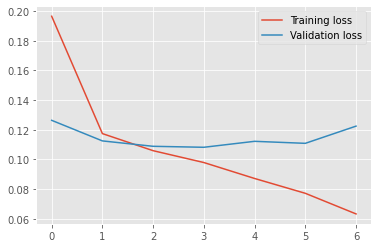

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.plot(hist_tm2["loss"], label='Training loss')
plt.plot(hist_tm2["val_loss"], label='Validation loss')
plt.legend()

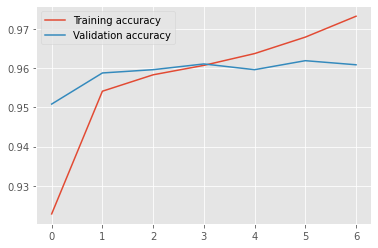

In [ ]:
plt.plot(hist_tm2["crf_viterbi_accuracy"], label='Training accuracy')
plt.plot(hist_tm2["val_crf_viterbi_accuracy"], label='Validation accuracy')
plt.legend()

In [ ]:
test_predictions_tm2 = tm2_model.predict([np.array(X_test[:160]), np.array(li_test[:160])], verbose=1)

160/160 [==============================] - 61s 379ms/step


In [ ]:
predicted_labels_tm2 = pred2label(test_predictions_tm2)
test_labels = pred2label(y_test[:160])

In [ ]:
print(predicted_labels_tm2[20])

['Neutral', 'Neutral', 'Neutral', 'Biased', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Biased', 'Biased', 'Biased', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [ ]:
print(test_labels[20])

['Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Biased', 'Neutral', 'Biased', 'Neutral', 'Biased', 'Biased', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Biased', 'Biased', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Biased', 'Biased', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [ ]:
!pip install seqeval

     |████████████████████████████████| 51kB 3.1MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp36-none-any.whl size=16171 sha256=f8fad0c730aa3a7cefe57fe12b5679c840e74508d76760692015786b3026b0c1
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval


In [ ]:
from seqeval.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, performance_measure
print("F1-score: {:.1%}".format(f1_score(test_labels, predicted_labels_tm2)))

F1-score: 41.9%


In [ ]:
print(classification_report(test_labels, predicted_labels_tm2))

              precision    recall  f1-score   support

      eutral       0.39      0.29      0.33       504
       iased       0.75      0.40      0.52       506

   micro avg       0.54      0.34      0.42      1010
   macro avg       0.57      0.34      0.42      1010
weighted avg       0.57      0.34      0.42      1010



In [ ]:
i = 20
p = np.argmax(test_predictions_tm1[i], axis=-1)
p

array([1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [ ]:
i = 28
p = np.argmax(test_predictions_tm2[i], axis=-1)
print("{:25} {:25} {}".format("Word", "True", "Pred"))
print("="*65)
for w, true, pred in zip(X_test[i], np.argmax(y_test[i], -1), p):
    if w != "PADDED":
        print("{:25}{:25} {}".format(w, idx2label[true], idx2label[pred]))

Word                      True                      Pred
but                      Neutral                   Neutral
the                      Neutral                   Neutral
president                Neutral                   Neutral
kept                     Neutral                   Neutral
his                      Neutral                   Neutral
word                     Neutral                   Neutral
when                     Neutral                   Neutral
it                       Neutral                   Neutral
came                     Neutral                   Neutral
to                       Neutral                   Neutral
the                      Neutral                   Neutral
court.                   Neutral                   Neutral
it’s                     Neutral                   Neutral
still                    Neutral                   Neutral
early                    Neutral                   Neutral
in                       Neutral                   Neutral

In [ ]:
li_all = np.append(li, li_test, axis=0)
li_all.shape

(1700, 50, 6)

# Train TM2 v2

> LSTM cells - 256

> Dropout - 25%, GRU droput - 25%

> Activation - softmax

In [ ]:
tm2_model = get_mutli_input_model()

In [ ]:
tm2_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
input_19 (InputLayer)           (None, 50, 6)        0                                            
__________________________________________________________________________________________________
lambda_11 (Lambda)              (None, 50, 1024)     0           input_18[0][0]                   
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 50, 6, 8)     400         input_19[0][0]                   
__________________________________________________________________________________________________
bidirectio

In [ ]:
plot_model(tm1_model, to_file='tm2_model_plot.png')

In [ ]:
history_tm2 = tm2_model.fit(
    [np.array(X_TR), np.array(X_TR_LIWC)], np.array(y_TR), 
    validation_data=([np.array(X_VAL), np.array(X_VAL_LIWC)], np.array(y_VAL)), 
    batch_size=batch_size, 
    epochs=10, 
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')],
    verbose=1
)

Train on 1408 samples, validate on 96 samples
Epoch 1/10
1408/1408 [==============================] - 597s 424ms/step - loss: 0.2138 - crf_viterbi_accuracy: 0.9303 - val_loss: 0.1370 - val_crf_viterbi_accuracy: 0.9583
Epoch 2/10
1408/1408 [==============================] - 568s 404ms/step - loss: 0.1339 - crf_viterbi_accuracy: 0.9553 - val_loss: 0.1295 - val_crf_viterbi_accuracy: 0.9565
Epoch 3/10
1408/1408 [==============================] - 569s 404ms/step - loss: 0.1234 - crf_viterbi_accuracy: 0.9577 - val_loss: 0.1266 - val_crf_viterbi_accuracy: 0.9588
Epoch 4/10
1408/1408 [==============================] - 567s 403ms/step - loss: 0.1111 - crf_viterbi_accuracy: 0.9612 - val_loss: 0.1345 - val_crf_viterbi_accuracy: 0.9540
Epoch 5/10
1408/1408 [==============================] - 566s 402ms/step - loss: 0.1019 - crf_viterbi_accuracy: 0.9636 - val_loss: 0.1311 - val_crf_viterbi_accuracy: 0.9617
Epoch 6/10
1408/1408 [==============================] - 567s 402ms/step - loss: 0.0895 - crf_v

In [ ]:
hist_tm2 = pd.DataFrame(history_tm2.history)

In [ ]:
print(hist_tm2.keys())

Index(['val_loss', 'val_crf_viterbi_accuracy', 'loss', 'crf_viterbi_accuracy'], dtype='object')


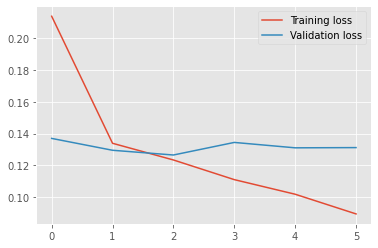

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.plot(hist_tm2["loss"], label='Training loss')
plt.plot(hist_tm2["val_loss"], label='Validation loss')
plt.legend()

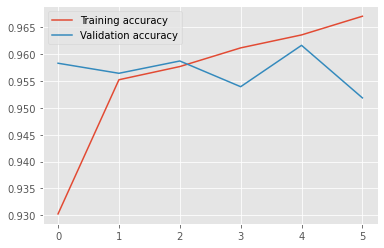

In [ ]:
plt.plot(hist_tm2["crf_viterbi_accuracy"], label='Training accuracy')
plt.plot(hist_tm2["val_crf_viterbi_accuracy"], label='Validation accuracy')
plt.legend()

In [ ]:
test_predictions_tm2 = tm2_model.predict([np.array(X_test[:160]), np.array(li_test[:160])], verbose=1)

160/160 [==============================] - 60s 376ms/step


In [ ]:
predicted_labels_tm2 = pred2label(test_predictions_tm2)
test_labels = pred2label(y_test[:160])

In [ ]:
print(predicted_labels_tm2[20])

['Neutral', 'Neutral', 'Neutral', 'Biased', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Biased', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [ ]:
print(test_labels[20])

['Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Biased', 'Neutral', 'Biased', 'Neutral', 'Biased', 'Biased', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Biased', 'Biased', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Biased', 'Biased', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [ ]:
from seqeval.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, performance_measure
print("F1-score: {:.1%}".format(f1_score(test_labels, predicted_labels_tm2)))

F1-score: 45.1%


In [ ]:
print(classification_report(test_labels, predicted_labels_tm2))

              precision    recall  f1-score   support

      eutral       0.35      0.34      0.34       504
       iased       0.61      0.52      0.56       506

   micro avg       0.47      0.43      0.45      1010
   macro avg       0.48      0.43      0.45      1010
weighted avg       0.48      0.43      0.45      1010



In [ ]:
i = 20
p = np.argmax(test_predictions_tm1[i], axis=-1)
p

array([1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [ ]:
i = 28
p = np.argmax(test_predictions_tm2[i], axis=-1)
print("{:25} {:25} {}".format("Word", "True", "Pred"))
print("="*65)
for w, true, pred in zip(X_test[i], np.argmax(y_test[i], -1), p):
    if w != "PADDED":
        print("{:25}{:25} {}".format(w, idx2label[true], idx2label[pred]))

Word                      True                      Pred
but                      Neutral                   Neutral
the                      Neutral                   Neutral
president                Neutral                   Neutral
kept                     Neutral                   Neutral
his                      Neutral                   Neutral
word                     Neutral                   Neutral
when                     Neutral                   Neutral
it                       Neutral                   Neutral
came                     Neutral                   Neutral
to                       Neutral                   Neutral
the                      Neutral                   Neutral
court.                   Neutral                   Neutral
it’s                     Neutral                   Neutral
still                    Neutral                   Neutral
early                    Neutral                   Neutral
in                       Neutral                   Neutral

In [ ]:
li_all = np.append(li, li_test, axis=0)
li_all.shape

(1700, 50, 6)

# Train TM2 v3

> LSTM cells - 256

> Dropout - 25%, GRU dropout - 20%

> Activation - softmax

In [ ]:
tm2_model = get_mutli_input_model()

In [ ]:
tm2_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 50, 6)        0                                            
__________________________________________________________________________________________________
lambda_10 (Lambda)              (None, 50, 1024)     0           input_11[0][0]                   
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 50, 6, 8)     80000       input_12[0][0]                   
__________________________________________________________________________________________________
bidirectio

In [ ]:
plot_model(tm1_model, to_file='tm2_model_plot.png')

In [ ]:
history_tm2 = tm2_model.fit(
    [np.array(X_TR), np.array(X_TR_LIWC)], np.array(y_TR), 
    validation_data=([np.array(X_VAL), np.array(X_VAL_LIWC)], np.array(y_VAL)), 
    batch_size=batch_size, 
    epochs=10, 
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')],
    verbose=1
)

Train on 1408 samples, validate on 96 samples
Epoch 1/10
1408/1408 [==============================] - 609s 433ms/step - loss: 0.2161 - acc: 0.9297 - val_loss: 0.1345 - val_acc: 0.9523
Epoch 2/10
1408/1408 [==============================] - 595s 422ms/step - loss: 0.1255 - acc: 0.9545 - val_loss: 0.1201 - val_acc: 0.9590
Epoch 3/10
1408/1408 [==============================] - 583s 414ms/step - loss: 0.1135 - acc: 0.9578 - val_loss: 0.1150 - val_acc: 0.9608
Epoch 4/10
1408/1408 [==============================] - 574s 408ms/step - loss: 0.1062 - acc: 0.9605 - val_loss: 0.1186 - val_acc: 0.9565
Epoch 5/10
1408/1408 [==============================] - 562s 399ms/step - loss: 0.0977 - acc: 0.9626 - val_loss: 0.1175 - val_acc: 0.9558
Epoch 6/10
1408/1408 [==============================] - 564s 400ms/step - loss: 0.0875 - acc: 0.9667 - val_loss: 0.1276 - val_acc: 0.9531


In [ ]:
hist_tm2 = pd.DataFrame(history_tm2.history)

In [ ]:
print(hist_tm2.keys())

Index(['val_loss', 'val_acc', 'loss', 'acc'], dtype='object')


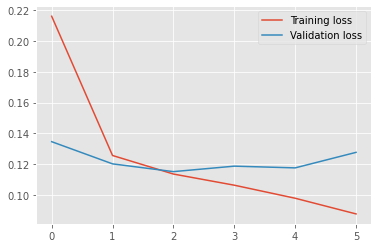

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.plot(hist_tm2["loss"], label='Training loss')
plt.plot(hist_tm2["val_loss"], label='Validation loss')
plt.legend()

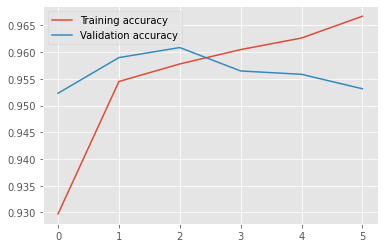

In [ ]:
plt.plot(hist_tm2["acc"], label='Training accuracy')
plt.plot(hist_tm2["val_acc"], label='Validation accuracy')
plt.legend()

In [ ]:
test_predictions_tm2 = tm2_model.predict([np.array(X_test[:160]), np.array(li_test[:160])], verbose=1)

160/160 [==============================] - 54s 337ms/step


In [ ]:
predicted_labels_tm2 = pred2label(test_predictions_tm2)
test_labels = pred2label(y_test[:160])

In [ ]:
print(predicted_labels_tm2[20])

['Neutral', 'Neutral', 'Neutral', 'Biased', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Biased', 'Biased', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [ ]:
print(test_labels[20])

['Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Biased', 'Neutral', 'Biased', 'Neutral', 'Biased', 'Biased', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Biased', 'Biased', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Biased', 'Biased', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [ ]:
from seqeval.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, performance_measure
print("F1-score: {:.1%}".format(f1_score(test_labels, predicted_labels_tm2)))

F1-score: 47.6%


In [ ]:
print(accuracy_score(test_labels, predicted_labels_tm2))

0.95025


In [ ]:
print(classification_report(test_labels, predicted_labels_tm2))

              precision    recall  f1-score   support

      eutral       0.37      0.37      0.37       504
       iased       0.62      0.56      0.59       506

   micro avg       0.49      0.46      0.48      1010
   macro avg       0.50      0.46      0.48      1010
weighted avg       0.50      0.46      0.48      1010



In [ ]:
i = 20
p = np.argmax(test_predictions_tm1[i], axis=-1)
p

array([1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [ ]:
i = 28
p = np.argmax(test_predictions_tm2[i], axis=-1)
print("{:25} {:25} {}".format("Word", "True", "Pred"))
print("="*65)
for w, true, pred in zip(X_test[i], np.argmax(y_test[i], -1), p):
    if w != "PADDED":
        print("{:25}{:25} {}".format(w, idx2label[true], idx2label[pred]))

Word                      True                      Pred
but                      Neutral                   Neutral
the                      Neutral                   Neutral
president                Neutral                   Neutral
kept                     Neutral                   Neutral
his                      Neutral                   Neutral
word                     Neutral                   Neutral
when                     Neutral                   Neutral
it                       Neutral                   Neutral
came                     Neutral                   Neutral
to                       Neutral                   Neutral
the                      Neutral                   Neutral
court.                   Neutral                   Neutral
it’s                     Neutral                   Neutral
still                    Neutral                   Neutral
early                    Neutral                   Neutral
in                       Neutral                   Neutral

In [ ]:
li_all = np.append(li, li_test, axis=0)
li_all.shape

(1700, 50, 6)

# TM2 - Save predicted sample



Correctly identified biased word sample

In [ ]:
biased_sample = []
for i in range(len(X_test[:160])):
  sentence = X_test[i]
  predicted_labels = np.argmax(test_predictions_tm2[i], axis=-1)
  true_labels = np.argmax(y_test[i], axis=-1)
  sentence_sample = []
  for w, true, pred in zip(sentence, true_labels, predicted_labels):
    if idx2label[pred] == "Biased" and idx2label[true] == "Biased":
      biased_sample.append(w)

print(biased_sample)

['ashamed', 'illegal', 'spurred', 'feverishly', 'lambasted', 'overwhelming', 'utter', 'failure', 'superior,', 'divisive', 'buffoon,', 'cynically', 'incompetent', 'inspired', 'tremendously', 'disaster', 'charged', 'claimed', 'best', 'jeopardize', 'bailing', 'out', 'crack', 'down', 'dismissed', 'pushed', 'hotbed', 'theorizing.', 'aggressively', 'ugly', 'rhetoric', 'intentionally', 'obscure', 'mismanagement', 'destabilizing', 'strong', 'justification', 'revered', 'threatened', 'hammer', 'accuse', 'sad', 'revelation.', 'upset', 'unusual', 'joked', 'interfere', 'opiate', 'white', 'nationalism', 'ugly', 'smearing', 'unbecoming', 'defying', 'confused', 'contradictory', 'blame', 'disgusting', 'dumb', 'slammed', 'aggressively', 'beaten', 'whopping', 'concocting', 'flashy', 'unprecedented', 'dramatically', 'lamented', 'spectacle”', 'denounce', 'provoked', 'impassioned', 'ignited', 'firestorm', 'bashing', 'squalid', 'poured', 'worst', 'deeply', 'intrusive', 'alarmist', 'remarkably', 'bad', 'disma

In [ ]:
len(biased_sample)

200

Write the sample in a file

In [ ]:
f=open('biased_sample_tm2.txt','w')
for word in biased_sample:
    f.write(word+', ')
f.close()